In [38]:
# Importing Libraries
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
from datetime import timedelta
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler, 
    Normalizer)
import matplotlib.lines as mlines

## The Plan!
- Chemometrics: Use BMK data to train a Chemometrics model

## To get marks: 
1. **Plotting:** Creat nice looking plots. Increase the complexity of the plots without deacreasing the legibility
2. **PANDAS:** Use Pandas to read/write/manipulate the data
3. **NUMPY:** How would I use NUMPY for this? 
4. **DATETIME:** Use the datetime module in Python 
5. **Machine Learning and Regression:** Use Scikit learn and some sort of regression to answer a question.
6. **Increase the range of the data:** How would I do this?  
 
#### Example:
- How much wind power is there at a particular location?
    - This is quite open ended, is this just the mean wind speed for
an hour/day/month/year, or should you take into account that
there are wind ranges that the windfarms can operate in. (min
max speeds)
    - Some analysis of what power when would be useful (time of
day/year)
- Are the wind speeds likely to be the same in 10 years in the future? ie
is there a trend in recorded wind speeds over the last few decades.
- Is there any other weather metric worth analyzing (eg rain, temp)
- What will the power output of the windfarms in Ireland be like next
week, according to the weather forecasts?

In [2]:
reference_raman_spectra= pd.read_csv("Raw Raman Data - Reference.csv", index_col=0)
reference_raman_spectra.head(n=20)

,0.625 mg/mL IgG1,1.25 mg/mL IgG1,2.5 mg/mL IgG1,5 mg/mL IgG1,10 mg/mL IgG1
RamanShift,,,,,
3425,1148563.488,1198165.702,1206325.744,1195576.347,1145206.568
3424,1147939.547,1200700.777,1209881.628,1200249.487,1143337.351
3423,1146370.469,1203749.020,1208789.471,1202838.240,1141521.697
3422,1146941.245,1207620.020,1206416.272,1204755.062,1142453.918
3421,1149270.003,1207036.815,1206870.556,1207518.608,1146454.739
3420,1151020.458,1202523.303,1210572.212,1210860.394,1151460.412
3419,1152588.026,1201949.196,1214764.209,1210049.996,1153391.413
3418,1152704.622,1205438.810,1216319.624,1204616.249,1150386.364
3417,1150840.010,1206759.138,1214491.418,1201500.448,1146095.797


In [3]:
experimental_raman_spectra= pd.read_csv("Raw Raman Data - Experiment.csv").T #Header=0 doesn't work here as transposition of the csv being read in occurs after that argument is passed
experimental_raman_spectra.columns=experimental_raman_spectra.iloc[0] #Set the first row as the column header.
experimental_raman_spectra.drop(index=experimental_raman_spectra.index[0], inplace=True) #Drop the first row
experimental_raman_spectra.head(n=20)

RamanShift (cm-1),3.166667,8.183333,13.183333,18.166667,23.183333,28.183333,33.183333,38.183333,43.183333,48.183333,53.183333,58.183333,63.183333,68.200000
3425,1781337.659,1773417.748,1788059.266,1792322.172,1777867.130,1774146.732,1787217.920,1786675.277,1779511.730,1788225.600,1772356.837,1662638.965,1734221.718,1733767.574
3424,1784070.893,1779908.423,1793350.673,1794223.501,1778261.178,1776087.531,1792257.386,1787794.559,1784296.506,1784350.966,1765856.329,1660755.707,1738868.342,1735666.025
3423,1784213.430,1783092.989,1796587.877,1793310.977,1780583.283,1777577.139,1798423.942,1788405.908,1783740.508,1781434.466,1764422.752,1663915.426,1736379.481,1738727.742
3422,1785077.556,1780479.128,1795893.368,1794067.141,1785154.087,1779767.395,1804203.414,1791386.044,1780540.869,1785527.640,1770307.491,1668102.333,1734063.291,1743231.899
3421,1788761.463,1776801.698,1791839.122,1798414.368,1786134.571,1781440.602,1804657.052,1793752.175,1781275.126,1790697.984,1778844.431,1670313.133,1739308.790,1746468.612
3420,1793117.657,1778499.115,1791067.149,1802199.146,1782864.379,1782296.498,1799820.852,1792101.234,1786205.050,1791144.193,1782507.883,1673186.193,1744550.628,1748747.497
3419,1795320.582,1781712.169,1795815.745,1804753.508,1781903.318,1785182.739,1798526.709,1789460.247,1788888.756,1791518.887,1780601.642,1678273.390,1744321.716,1750484.314
3418,1795560.779,1780453.783,1799200.087,1808070.269,1784138.285,1789525.191,1804005.256,1792004.870,1785302.431,1795285.893,1779009.008,1682170.651,1745353.538,1749088.623
3417,1796205.625,1779105.692,1798065.690,1808942.475,1785080.779,1789690.913,1809480.054,1795759.257,1778670.308,1800308.999,1780017.481,1682443.498,1748955.104,1745974.920
3416,1797329.744,1781236.232,1796928.242,1803749.116,1784498.039,1784510.542,1809384.791,1793147.619,1775501.175,1803931.964,1779997.423,1681524.104,1750123.671,1745822.354


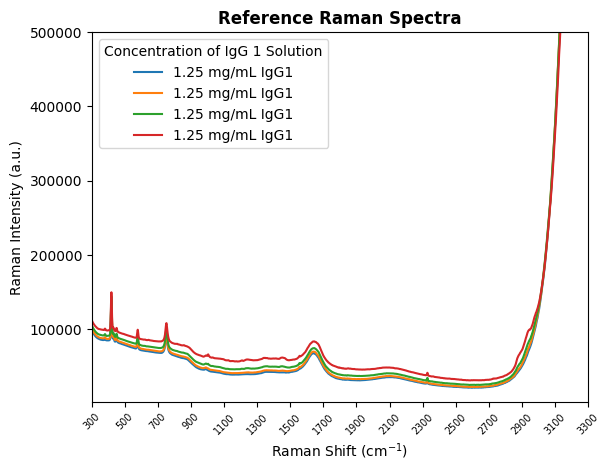

In [4]:
ramanshift=np.sort(np.array(reference_raman_spectra.index, dtype=int)) #Need to sort the wavenumbers for the x-axis 

fig, ax = plt.subplots()
for i in reference_raman_spectra.columns[1:]:
    ax.plot(
        reference_raman_spectra.index,
        reference_raman_spectra[i],
        label=f"{reference_raman_spectra.columns[1:][0]}"
    )
ax.set_xticks(ramanshift[::200])
ax.set_xticklabels(ramanshift[::200], rotation=45, 
                   fontdict= {'fontsize': 'x-small',}
                   )
ax.set_xlim(300,3300)
ax.set_ylim(2500,0.5e6)
ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
ax.set_ylabel("Raman Intensity (a.u.)")
ax.set_title("Reference Raman Spectra",
             fontdict = {'fontsize': 'large','fontweight' : "bold",}
             )
ax.legend(title= "Concentration of IgG 1 Solution")

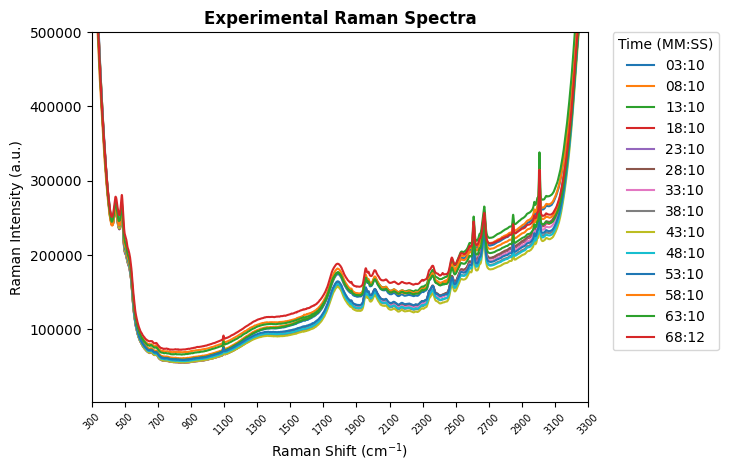

In [5]:
#Generation of the x-axis 
wavenumbers = np.sort(np.array(experimental_raman_spectra.index, dtype=int))

#Formatting the time data for the legend:
#Use timedelta to convert the data frame columns (1D array of  dtype='float64') to MM:SS
sampling_time = [timedelta(minutes=minutes) for minutes in experimental_raman_spectra.columns]
sampling_time_formatted = [f"{(time.seconds//60):02}:{(time.seconds%60):02}" for time in sampling_time]

fig, ax = plt.subplots()

for column in experimental_raman_spectra:
    ax.plot(
        experimental_raman_spectra.index,
        experimental_raman_spectra[column],
        label=column
    )
ax.set_xticks(wavenumbers[::200])
ax.set_xticklabels(wavenumbers[::200], rotation=45, 
                   fontdict= {'fontsize': 'x-small',}
                   )
ax.set_xlim(300,3300)
ax.set_ylim(2500,0.5e6)
ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
ax.set_ylabel("Raman Intensity (a.u.)")
ax.set_title("Experimental Raman Spectra",
             fontdict = {'fontsize': 'large','fontweight' : "bold",}
             )
ax.legend(title= "Time (MM:SS)",
          labels= sampling_time_formatted,
          loc="upper left",
          bbox_to_anchor=(1.05, 1),
          borderaxespad=0
          )

Text(0.5, 0.98, 'Experimental Raman Spectra')

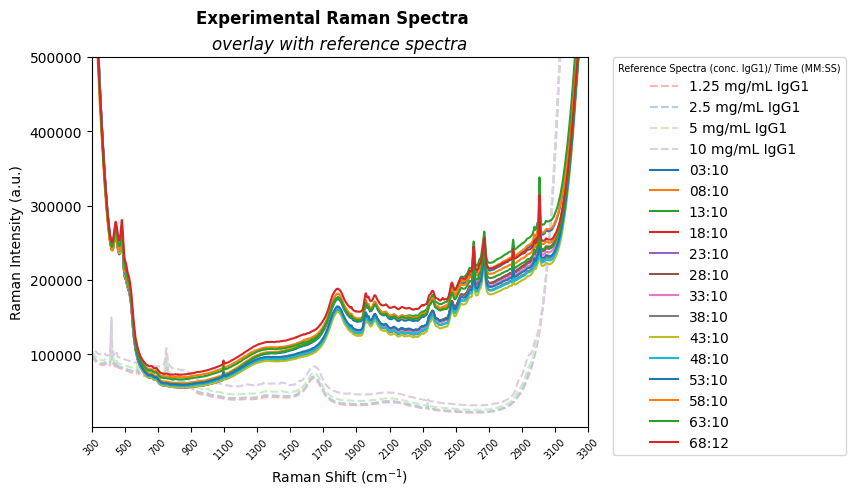

In [6]:
#https://matplotlib.org/stable/users/explain/colors/colormaps.html
# https://matplotlib.org/stable/gallery/color/named_colors.html, 
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
#https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html#colormap-manipulation

colours_for_reference=cm.Pastel1.colors
legend_labels= reference_raman_spectra.columns[1:].to_list() + sampling_time_formatted

fig, ax = plt.subplots()

for idx, i in (enumerate(reference_raman_spectra.columns[1:])): #Gives each Column an index id to call for the list of colours I want to use
    ax.plot(
        reference_raman_spectra.index,
        reference_raman_spectra[i],
        linestyle="--",
        color=colours_for_reference[idx] #Cycle through the pastel colour map list
        # label=f"{reference_raman_spectra.columns[1:][0]}"
    )

for column in experimental_raman_spectra:
    ax.plot(
        experimental_raman_spectra.index,
        experimental_raman_spectra[column],
        linestyle="-",
        # label=column
    )
ax.set_xticks(wavenumbers[::200])
ax.set_xticklabels(wavenumbers[::200], rotation=45, 
                   fontdict= {'fontsize': 'x-small',}
                   )
ax.set_xlim(300,3300)
ax.set_ylim(2500,0.5e6)
ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
ax.set_ylabel("Raman Intensity (a.u.)")
ax.set_title(f"overlay with reference spectra",
             fontdict = {'fontsize': 'large','fontstyle' : "italic",}
             )
ax.legend(
          title= "Reference Spectra (conc. IgG1)/ Time (MM:SS)",
          labels= legend_labels,
          loc="upper left",
          bbox_to_anchor=(1.05, 1),
          borderaxespad=0,
          title_fontsize="x-small"
          )
fig.suptitle(f"Experimental Raman Spectra",
             fontweight="bold"
             )

## To do: 
- Use SNV to normalise the data
**Why Use SNV?**
The SNV technique helps reduce scatter and improve the clarity of the signal that really matters in Near-IR data. By minimizing noise, it allows for more accurate interpretation of the spectra and better overall results when applying models for analysis - from this [Medium article](https://medium.com/@chrisjpulliam/standard-normal-variate-snv-signal-processing-for-near-ir-data-f9bb7a96a42d) or the use of SNV for Near-IR data. 

Scikit learn preprocessing tool documentation: 
- https://scikit-learn.org/1.5/modules/preprocessing.html
- https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py
- https://stackoverflow.com/questions/39120942/difference-between-standardscaler-and-normalizer-in-sklearn-preprocessing


In [7]:
normalised_reference_spectra=preprocessing.StandardScaler().fit_transform(np.array(reference_raman_spectra))
normalised_experimental_spectra=preprocessing.StandardScaler().fit_transform(np.array(experimental_raman_spectra))
#Make the arrays of normalised array of data back into Pandas dataframes for matplotlib plotting: 
normalised_reference_spectra_df = pd.DataFrame(
    normalised_reference_spectra,
    index=reference_raman_spectra.index,
    columns=reference_raman_spectra.columns
)
normalised_experimental_spectra_df= pd.DataFrame(
    normalised_experimental_spectra,
    index=experimental_raman_spectra.index,
    columns=sampling_time_formatted
)

Text(0.5, 0.98, 'Experimental Raman Spectra')

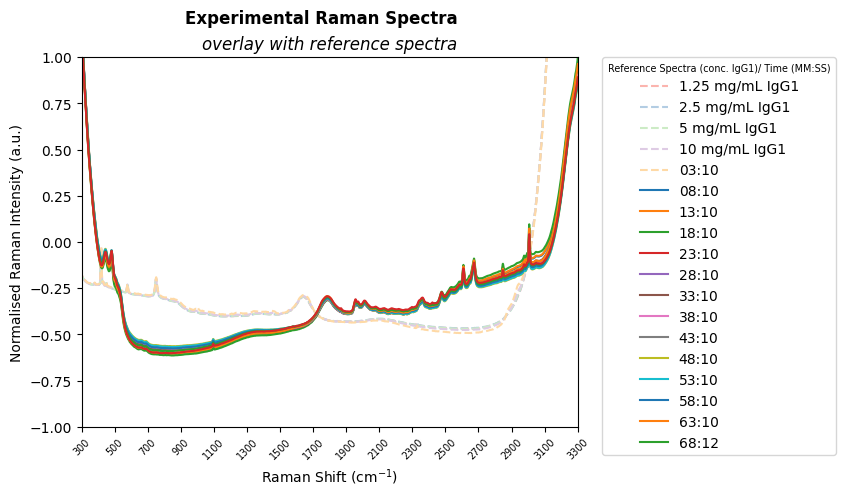

In [8]:
#PLOT THE DATA:
#Set up the colour maps and legend labels as before
colours_for_reference=cm.Pastel1.colors
legend_labels= reference_raman_spectra.columns[1:].to_list() + sampling_time_formatted
fig,ax=plt.subplots()
#Plot the reference spectra:
for idx, column in enumerate(normalised_reference_spectra_df): #Gives each Column an index id to call for the list of colours I want to use
    ax.plot(
        normalised_reference_spectra_df.index,
        normalised_reference_spectra_df[column],
        linestyle="--",
        color=colours_for_reference[idx] 
    )
#Plot the experimental data: 
for column in normalised_experimental_spectra_df:
    ax.plot(
        normalised_experimental_spectra_df.index,
        normalised_experimental_spectra_df[column],
        linestyle="-",
    )

ax.set_xticks(wavenumbers[::200])
ax.set_xticklabels(wavenumbers[::200], rotation=45, 
                   fontdict= {'fontsize': 'x-small',}
                   )
ax.set_xlim(300,3300)
ax.set_ylim(-1,1)
ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
ax.set_ylabel("Normalised Raman Intensity (a.u.)")
ax.set_title(f"overlay with reference spectra",
             fontdict = {'fontsize': 'large','fontstyle' : "italic",}
             )
ax.legend(
          title= "Reference Spectra (conc. IgG1)/ Time (MM:SS)",
          labels= legend_labels,
          loc="upper left",
          bbox_to_anchor=(1.05, 1),
          borderaxespad=0,
          title_fontsize="x-small"
          )
fig.suptitle(f"Experimental Raman Spectra",
             fontweight="bold"
             )

## To do:
- Do I need a different normalisation? 
- Fix the legend title
- Change the colour scheme

In [9]:
SNV_scaled_reference_spectra=preprocessing.StandardScaler().fit_transform(np.array(reference_raman_spectra))
SNV_scaled_experimental_spectra=preprocessing.StandardScaler().fit_transform(np.array(experimental_raman_spectra))

minmax_scaled_reference_spectra=MinMaxScaler().fit_transform(np.array(reference_raman_spectra))
minmax_scaled_experimental_spectra=MinMaxScaler().fit_transform(np.array(experimental_raman_spectra))

maxabs_scaled_reference_spectra=MaxAbsScaler().fit_transform(np.array(reference_raman_spectra))
maxabs_scaled_experimental_spectra=MaxAbsScaler().fit_transform(np.array(experimental_raman_spectra))

#Make the arrays of scaled array of data back into Pandas dataframes for matplotlib plotting: 
SNV_scaled_reference_spectra_df = pd.DataFrame(
    SNV_scaled_reference_spectra,
    index=reference_raman_spectra.index,
    columns=reference_raman_spectra.columns
)
SNV_scaled_experimental_spectra_df= pd.DataFrame(
    SNV_scaled_experimental_spectra,
    index=experimental_raman_spectra.index,
    columns=sampling_time_formatted
)

minmax_scaled_reference_spectra_df = pd.DataFrame(
    minmax_scaled_reference_spectra,
    index=reference_raman_spectra.index,
    columns=reference_raman_spectra.columns
)
minmax_scaled_experimental_spectra_df= pd.DataFrame(
    minmax_scaled_experimental_spectra,
    index=experimental_raman_spectra.index,
    columns=sampling_time_formatted
)

maxabs_scaled_reference_spectra_df = pd.DataFrame(
    maxabs_scaled_reference_spectra,
    index=reference_raman_spectra.index,
    columns=reference_raman_spectra.columns
)
maxabs_scaled_experimental_spectra_df= pd.DataFrame(
    maxabs_scaled_experimental_spectra,
    index=experimental_raman_spectra.index,
    columns=sampling_time_formatted
)

In [ ]:
### The above code should probably be done in a for loop! 
### I am going to use dictionaries with keys to store the different scalers: 
# scalers = {
#     "SNV": preprocessing.StandardScaler(),
#     "minmax": MinMaxScaler(),
#     "maxabs": MaxAbsScaler()
# }
# # scalers.items() # returns the dict objects 

# scaled_experimental_data_dict = {} #Empty Dict to save the output of the for loop to! 
# # For loop to loop over each scaler for the experimnetal data: 
# for scaler_name, scaler in scalers.items():
#     # print(scaler_name, scaler)
#     scaled_key = f"{scaler_name}_scaled_experimental_spectra"
#     scaled_experimental_data_dict[scaled_key] = scaler.fit_transform(np.array(experimental_raman_spectra))
# #Do the same with the reference spectra:
# scaled_reference_spectra_dict = {}
# for scaler_name, scaler in scalers.items():
#     scaled_key = f"{scaler_name}_scaled_reference_spectra"
#     scaled_experimental_data_dict[scaled_key] = scaler.fit_transform(np.array(reference_raman_spectra))

Text(0.5, 0.98, 'Reference and Experimental Raman Spectra Overlay')

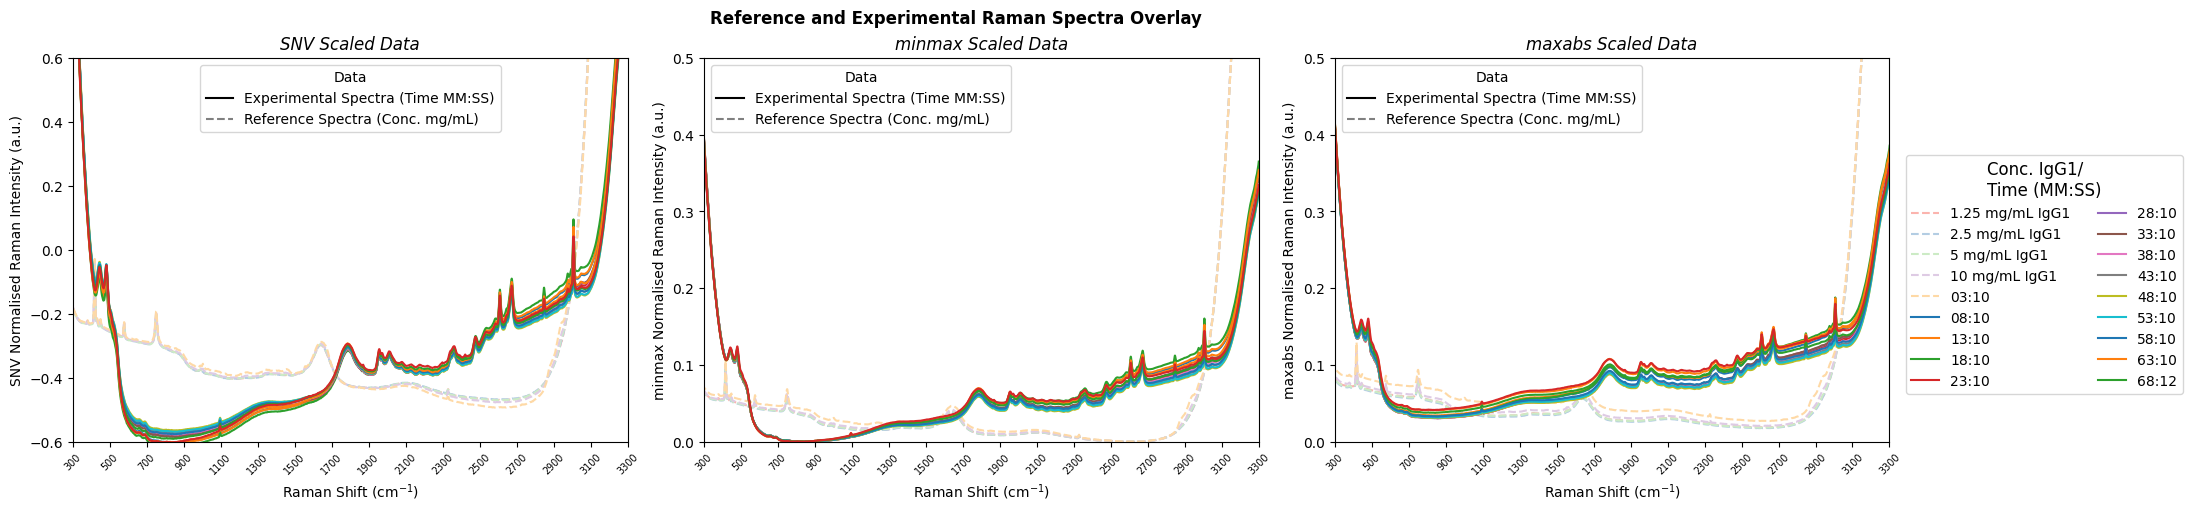

In [52]:
scaled_data_frames = {
    "SNV_scaled_reference_spectra_df": SNV_scaled_reference_spectra_df,
    "SNV_scaled_experimental_spectra_df": SNV_scaled_experimental_spectra_df,
    "minmax_scaled_reference_spectra_df": minmax_scaled_reference_spectra_df,
    "minmax_scaled_experimental_spectra_df": minmax_scaled_experimental_spectra_df,
    "maxabs_scaled_reference_spectra_df": maxabs_scaled_reference_spectra_df,
    "maxabs_scaled_experimental_spectra_df": maxabs_scaled_experimental_spectra_df,
}

#PLOT THE DATA:
#Set up the colour maps and legend labels as before
colours_for_reference=cm.Pastel1.colors
legend_labels= reference_raman_spectra.columns[1:].to_list() + sampling_time_formatted

fig,ax=plt.subplots(1, 3, figsize=(19, 5), layout = "constrained") 

for i, scaler in enumerate(["SNV", "minmax", "maxabs"]):
    reference_data_scaled = scaled_data_frames[f"{scaler}_scaled_reference_spectra_df"]
    experimental_data_scaled = scaled_data_frames[f"{scaler}_scaled_experimental_spectra_df"]
    #Plot the reference spectra:
    for idx, column in enumerate(reference_data_scaled): #Gives each Column an index id to call for the list of colours I want to use
        ax[i].plot(
            reference_data_scaled.index,
            reference_data_scaled[column],
            linestyle="--",
            color=colours_for_reference[idx])
    #Plot the experimental data: 
    for column in experimental_data_scaled:
        ax[i].plot(
            experimental_data_scaled.index,
            experimental_data_scaled[column],
            linestyle="-",)
    ax[i].set_xticks(wavenumbers[::200])
    ax[i].set_xticklabels(wavenumbers[::200], rotation=45,fontdict= {'fontsize': 'x-small',})
    ax[i].set_xlim(300,3300)
    # ax[i].set_ylim(0,0.5)
    if scaler == "SNV":
        ax[i].set_ylim(-0.6, 0.6) 
    else:
        ax[i].set_ylim(0, 0.5) 
    ax[i].set_xlabel(r'Raman Shift (cm$^{-1})$')
    ax[i].set_ylabel(f"{scaler} Normalised Raman Intensity (a.u.)")
    ax[i].set_title(f"{scaler} Scaled Data",fontdict = {'fontsize': 'large','fontstyle' : "italic",})
    dashed_line = mlines.Line2D([], [], color='grey', linestyle="--", label='Reference Spectra (Conc. mg/mL)')
    solid_line = mlines.Line2D([], [], color='black', linestyle="-", label='Experimental Spectra (Time MM:SS)')
    ax[i].legend(title="Data", handles=[solid_line, dashed_line])


# References for fixing the legend: 
# https://matplotlib.org/stable/users/explain/axes/legend_guide.html#legend-guide - creating proxty artists example ! Using mlines ... 
fig.legend(title= "Conc. IgG1/\nTime (MM:SS)",
            labels= legend_labels,
            loc="upper left",
            ncol=2,
            bbox_to_anchor=(1, 0.7),
            borderaxespad=0,
            title_fontsize="large"
            )
fig.suptitle(f"Reference and Experimental Raman Spectra Overlay",
             fontweight="bold"
             )
# References for fixing the legend: 
# https://matplotlib.org/stable/users/explain/axes/legend_guide.html#legend-guide - creating proxty artists example ! Using mlines ... 

*********************
# *END*